In [1]:
import numpy as np
np.random.seed(100)
import matplotlib.pyplot as plt
import cv2
import glob
import h5py
import seaborn as sns
from matplotlib.collections import PathCollection
import pandas as pd

In [2]:
# for plot figures
plt.rcParams['svg.fonttype'] = 'none'
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

In [3]:
#camera spectral calibration
def funcUV(x, a, b, c):
    return a * np.power(x,b) + c
poptUV=np.array([0.741,2.102,0.015])
def funcG(x, a, b, c):
    return a * np.power(x,b) + c
poptG=np.array([6.197,4.331,0.366])

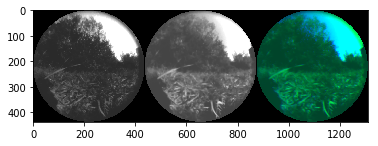

In [4]:
img_old=cv2.imread('./data/overlay_ss.tiff')
img_old=img_old[...,::-1]/255.0 #rgb
img_new=np.copy(img_old)
img_view=np.copy(img_old)
img_real=np.copy(img_old)
img_new[...,-1]=funcUV(img_old[...,-1],*poptUV)
img_new[...,1]=funcG(img_old[...,1],*poptG)
img_new[np.where( img_new < 0.0 )]=0.0  
tempUV=poptUV[0]+poptUV[2]
tempG=poptG[0]+poptG[2]
img_real[...,1]=img_new[...,1]/tempG 
img_real[...,-1]=img_new[...,-1]/tempUV 
gamma_correction=lambda x:np.power(x,1.0/2.2)
img_view[...,-1]=gamma_correction(img_real[...,-1])
img_view[...,1]=gamma_correction(img_real[...,1])
img_view=np.uint8(img_view[...,::-1]*255) #bgr,255
mask=cv2.imread('./data/video1_mask1_small_square.tiff')[:,:,0]
img_view=cv2.bitwise_and(img_view,img_view,mask=mask)
img_view_3cols=np.zeros((437,437*3,3),dtype=np.uint8)
img_view_3cols[:,:437,0]=img_view[...,0] #UV
img_view_3cols[:,:437,1]=img_view[...,0]
img_view_3cols[:,:437,2]=img_view[...,0]
img_view_3cols[:,437:437*2,0]=img_view[...,1] #G
img_view_3cols[:,437:437*2,1]=img_view[...,1]
img_view_3cols[:,437:437*2,2]=img_view[...,1]
img_view_3cols[:,437*2:,:]=img_view #overlay
plt.imshow(img_view_3cols[...,::-1])

(27, 30, 3)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f71c0a11b00>,
 Text(0.5, 1.0, 'after calib, view'))

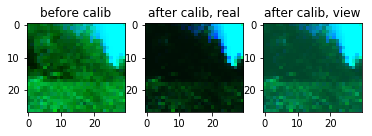

In [5]:
img_old=cv2.imread('./data/overlay_ss.tiff')
img_old=img_old[70:330,80:370,::-1]/255.0 
img_old = cv2.resize(img_old, (0,0), fx=1/9.6, fy=1/9.6) 
print (img_old.shape)
img_new=np.copy(img_old)
img_view=np.copy(img_old)
img_real=np.copy(img_old)
img_new[...,-1]=funcUV(img_old[...,-1],*poptUV)
img_new[...,1]=funcG(img_old[...,1],*poptG)
img_new[np.where( img_new < 0.0 )]=0.0  
tempUV=poptUV[0]+poptUV[2]
tempG=poptG[0]+poptG[2]
img_real[...,1]=img_new[...,1]/tempG 
img_real[...,-1]=img_new[...,-1]/tempUV 
gamma_correction=lambda x:np.power(x,1.0/2.2)
img_view[...,-1]=gamma_correction(img_real[...,-1])
img_view[...,1]=gamma_correction(img_real[...,1])
#
plt.figure()
plt.subplot(131),plt.imshow(img_old),plt.title('before calib')
plt.subplot(132),plt.imshow(img_real),plt.title('after calib, real')
plt.subplot(133),plt.imshow(img_view),plt.title('after calib, view')

(27, 30, 3)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f71c09842b0>,
 Text(0.5, 1.0, 'view'))

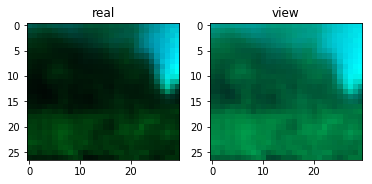

In [6]:
#spectrometer STS-UV
spe_view=cv2.imread('./data/spectrometer_image_view.tiff')[:-3,:,::-1]/255.0
spe_real=cv2.imread('./data/spectrometer_image_real.tiff')[:-3,:,::-1]/255.0
print (spe_real.shape)
plt.subplot(121),plt.imshow(spe_real),plt.title('real')
plt.subplot(122),plt.imshow(spe_view),plt.title('view')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f71c08e9a90>,
 Text(0.5, 1.0, 'G'))

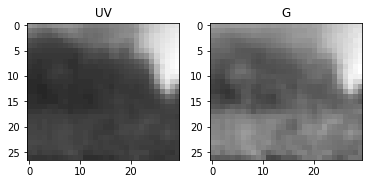

In [7]:
#check spe_view in UV and green channel separately
plt.subplot(121),plt.imshow(spe_view[...,-1],vmin=0,vmax=1,cmap='gray'),plt.title('UV')
plt.subplot(122),plt.imshow(spe_view[...,1],vmin=0,vmax=1,cmap='gray'),plt.title('G')

In [8]:
#grass, tree, sky intensity
grass_img_old=img_old[19:24,3:27,:] 
tree_img_old=img_old[8:13,3:21,:] 
sky_img_old=img_old[4:10,27:30,:] 
#
grass_img_real=img_real[19:24,3:27,:]
tree_img_real=img_real[8:13,3:21,:]
sky_img_real=img_real[4:10,27:30,:]
#
grass_spe_real=spe_real[19:24,3:27,:]
tree_spe_real=spe_real[8:13,3:21,:]
sky_spe_real=spe_real[4:10,27:30,:]

In [11]:
alldata=[grass_img_old,grass_img_real,grass_spe_real,\
      tree_img_old, tree_img_real, tree_spe_real,\
      sky_img_old,  sky_img_real,  sky_spe_real]
def namestr(obj, namespace): 
    return [name for name in namespace if namespace[name] is obj]
for ii in alldata:
    tempstr=namestr(ii, globals())
    print (tempstr[0] if len(tempstr[0])>len(tempstr[1]) else tempstr[1])

grass_img_old
grass_img_real
grass_spe_real
tree_img_old
tree_img_real
tree_spe_real
sky_img_old
sky_img_real
sky_spe_real


In [12]:
#violin plot 
col_names =  ['intensity', 'category', 'label']
my_df  = pd.DataFrame(columns = col_names)
alldata=[grass_img_old,grass_img_real,grass_spe_real,\
      tree_img_old, tree_img_real, tree_spe_real,\
      sky_img_old,  sky_img_real,  sky_spe_real]
def namestr(obj, namespace): 
    return [name for name in namespace if namespace[name] is obj]
for ii in alldata:
    tempstr=namestr(ii, globals())
    tempname=tempstr[0] if len(tempstr[0])>len(tempstr[1]) else tempstr[1]
    if 'grass' in tempname:
        tempcate='Grass'
    elif 'tree' in tempname:
        tempcate='Tree'
    elif 'sky' in tempname:
        tempcate='Sky'
    if 'old' in tempname:
        templabel='Camera w/o calib.-'
    elif 'img_real' in tempname:
        templabel='Camera, mea.-'
    elif 'spe_real' in tempname:
        templabel='Spec., mea.-'
    ii=np.reshape(ii,(-1,3)) 
    for jj in range(len(ii)):
        my_df=my_df.append({'intensity':ii[jj,-1],\
                            'category':tempcate,\
                            'label':templabel+'UV'}, ignore_index=True)
        my_df=my_df.append({'intensity':ii[jj,1],\
                            'category':tempcate,\
                            'label':templabel+'G'}, ignore_index=True)

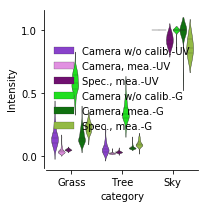

In [13]:
fig, ax = plt.subplots(figsize=(3,3))
ax = sns.violinplot(x="category",y="intensity",hue='label',data=my_df,hue_order=\
                    ['Camera w/o calib.-UV','Camera, mea.-UV',\
                     'Spec., mea.-UV','Camera w/o calib.-G',
                     'Camera, mea.-G','Spec., mea.-G'],
                     palette=['blueviolet','violet','purple',\
                              'lime','g','yellowgreen'],color='0.1',\
                     scale_hue=True,inner='quartile',linewidth=0.4,width=0.8,scale='width')

ax.set_ylabel('Intensity')
ax.set_yticks([0,0.5,1])
ax.legend(loc='best',frameon=False)
adjust_spines(ax, ['left', 'bottom'])
fig.tight_layout()